In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [2]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [3]:
#### importante:
def prepare_lc(fluxs, tipo='min'): #dividir por min
    fluxs = np.asarray(fluxs)
    if tipo=='min':
        v = np.abs(np.nanmin(fluxs))
    elif tipo=='std':
        v = np.nanstd(fluxs)
    else:
        v = 1
    return fluxs/v


###### NEW #########
dirpath = os.getcwd().split("code")[0]+"code/obj4"
sys.path.append(dirpath)
from fold import *

def global_fold(t, fluxs, per, t0, T=1000):
    t_fold, val_fold = phase_fold_and_sort_light_curve(t, fluxs, period= per, t0= t0)
    return global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)


from code_MTF import create_MTF_gN

In [7]:
coupled_LC = []
coupled_deltaT = []
coupled_deltaT_log = []
for i in range(our_process.shape[0]):
    #borrar nans... arreglo variable
    mask_nan_aux = np.isnan(our_process[i])
    coupled_LC.append(our_process[i][~mask_nan_aux])
    time_i = time_kepler[i][~mask_nan_aux]
    coupled_deltaT.append(np.hstack([[0],np.diff(time_i)]))
    coupled_deltaT_log.append(np.log(coupled_deltaT[-1]+1))
    
coupled_LC = np.asarray(coupled_LC)
coupled_deltaT = np.asarray(coupled_deltaT)
coupled_deltaT_log = np.asarray(coupled_deltaT_log)

coupled_deltaT

array([array([0.       , 0.0204347, 0.0204346, ..., 0.0204347, 0.0204346,
       0.0204347]),
       array([0.       , 0.0408658, 0.0204329, ..., 0.0204347, 0.0204345,
       0.0204348]),
       array([0.       , 0.0204347, 0.0204345, ..., 0.0204346, 0.0204346,
       0.0204347]),
       ...,
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204342, 0.0204342, ..., 0.0204341, 0.0204341,
       0.0204343])], dtype=object)

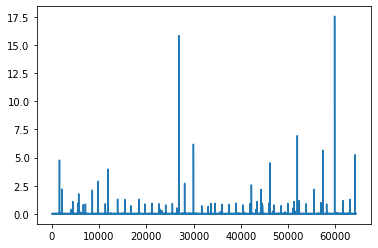

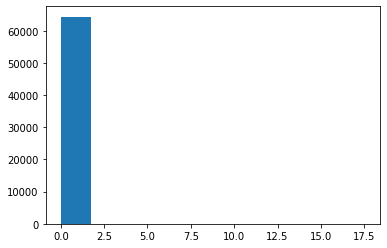

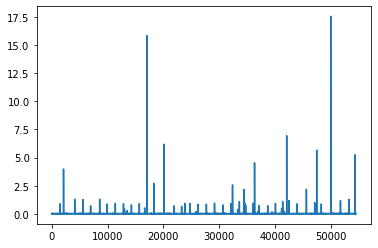

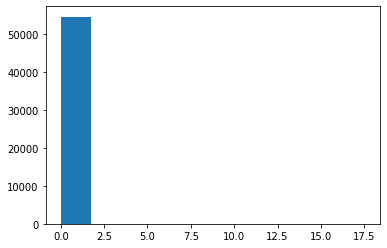

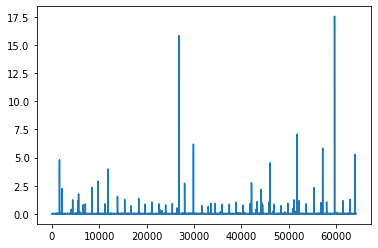

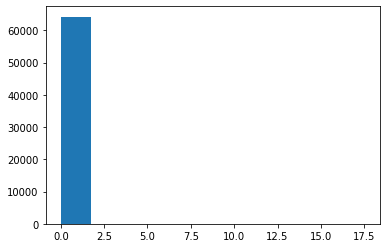

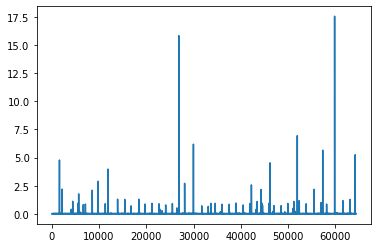

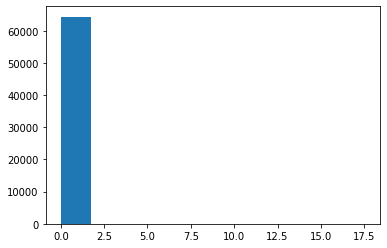

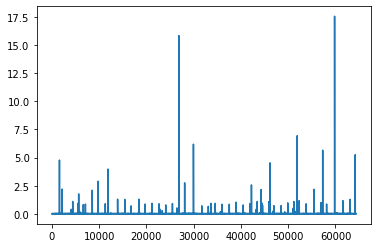

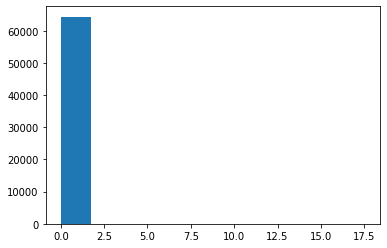

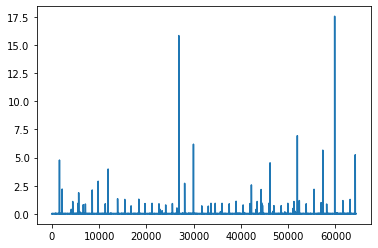

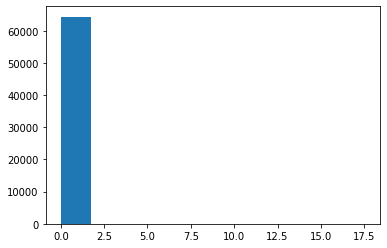

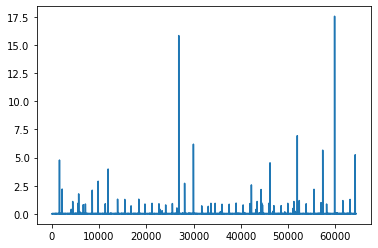

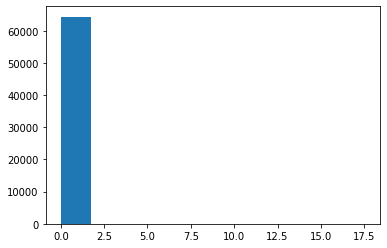

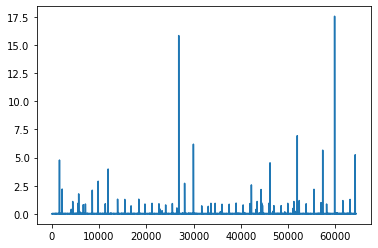

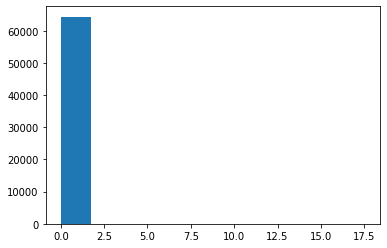

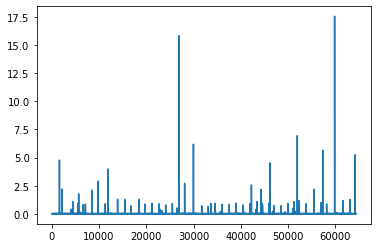

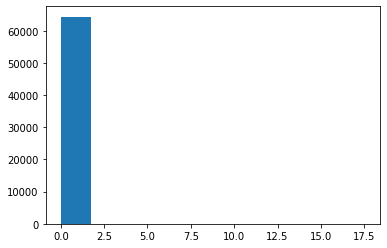

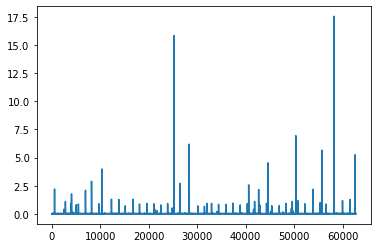

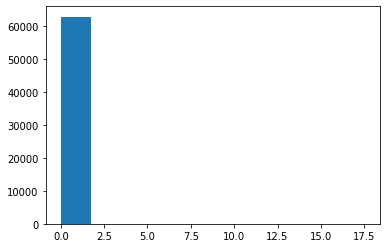

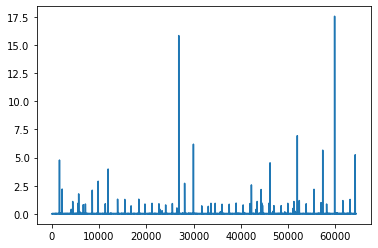

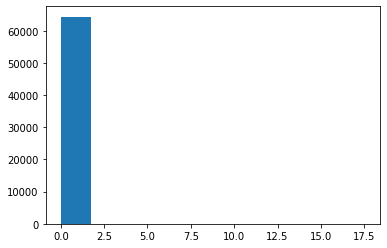

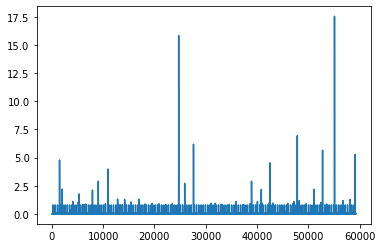

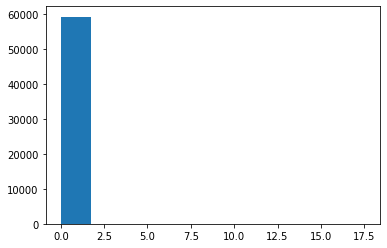

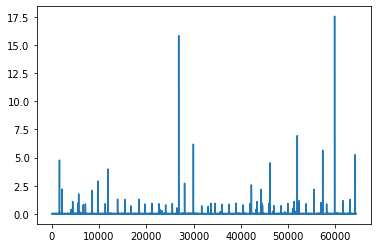

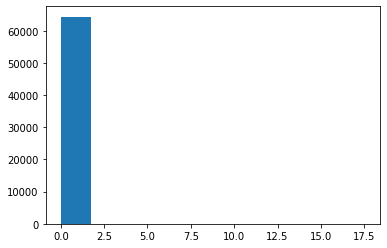

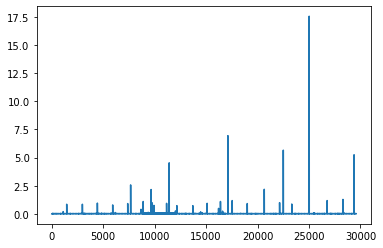

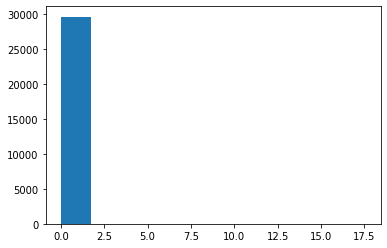

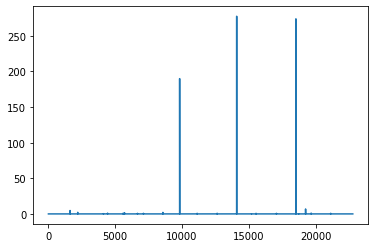

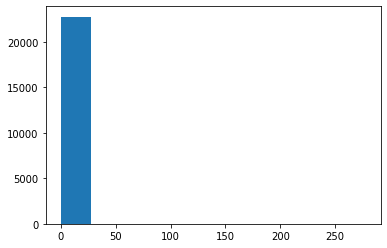

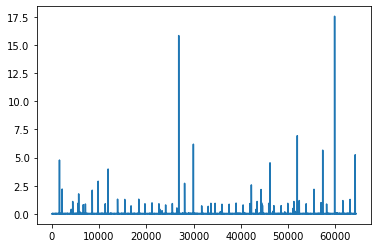

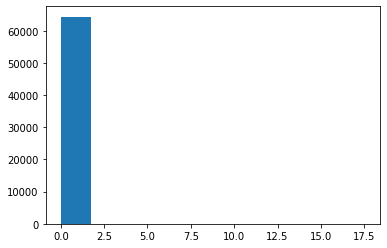

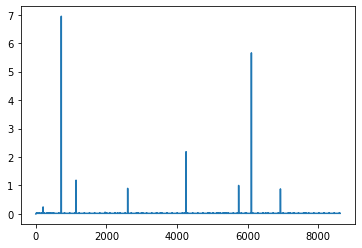

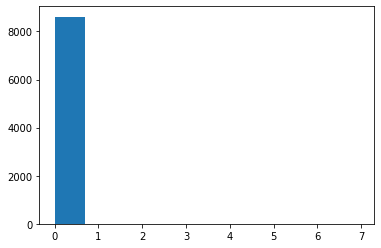

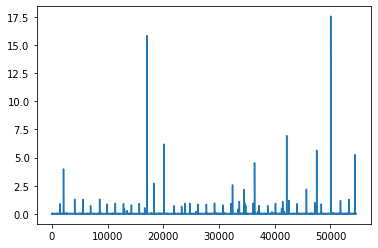

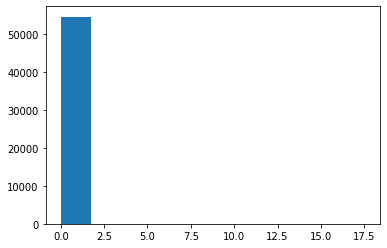

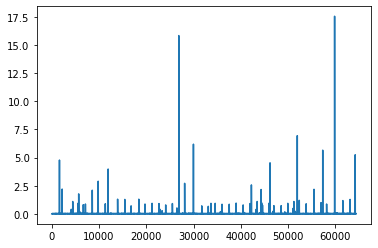

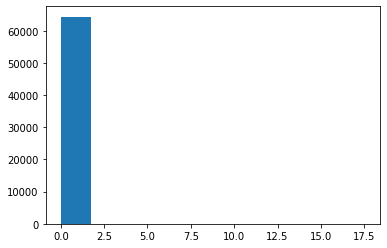

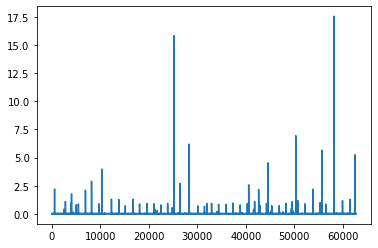

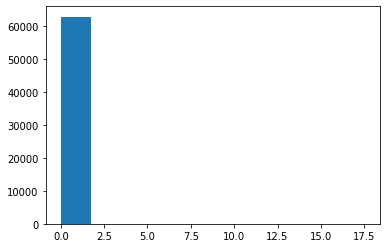

In [36]:
for i in range(20):
    plt.plot(coupled_deltaT[i])
    plt.show()
    plt.hist(coupled_deltaT[i])
    plt.show()

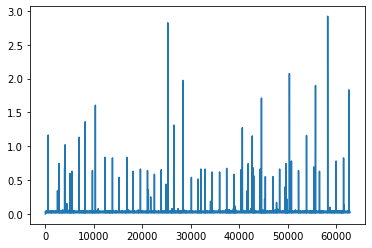

In [44]:
plt.plot(np.log(coupled_deltaT[i]+1))
plt.show()

In [240]:
m_std = []
for i in range(coupled_deltaT.shape[0]):
    m_std.append(np.std(coupled_deltaT[i]))
m_std

[0.1141529908174273,
 0.12051967666417396,
 0.1150494870661587,
 0.11414108601693647,
 0.11424093461341256,
 0.11426208910348166,
 0.11416327921187588,
 0.11415527463743781,
 0.11416428937162373,
 0.11403099117814779,
 0.11415517140306905,
 0.12476304692554732,
 0.11415054842309105,
 0.12586182780599847,
 2.8735824190988266,
 0.11417225670931905,
 0.10125121099847148,
 0.1204576319531664,
 0.11415751652591932,
 0.11406645061702603,
 0.11668242133692266,
 0.11417217001716382,
 0.11636736426665492,
 0.12127337386207479,
 0.11429486214724642,
 0.11415954837328582,
 0.11416786878685375,
 0.11416240368208172,
 0.11418053988106783,
 0.1141695194725884,
 0.12336543267567572,
 0.12050253527576688,
 1.7290600132722038,
 0.11417255122566565,
 0.11419017786398951,
 0.11404506810291698,
 0.11417709110680709,
 0.11417409303745873,
 0.11417686491718294,
 0.12422503792598391,
 0.11415139288763344,
 0.17971131059984802,
 0.11416075805723078,
 0.11416830230992565,
 0.11405660052661744,
 0.1141745325738

In [245]:
np.argsort(m_std)[::-1]

array([5912, 2341, 5796, ..., 4914, 5913, 6434])

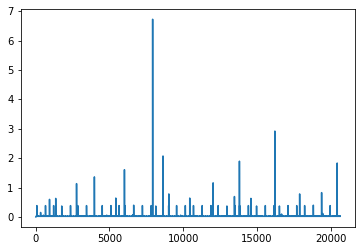

In [26]:
plt.plot(coupled_deltaT_log[5796])

In [46]:
maximos = []
for i in range(coupled_deltaT.shape[0]):
    maximos.append(np.max(coupled_deltaT[i]))
maximos

[17.551969199999803,
 17.55196920000003,
 17.5519726,
 17.55197209999983,
 17.551967200000036,
 17.55197249999992,
 17.55197350000003,
 17.55197350000003,
 17.551971500000036,
 17.55196570000021,
 17.551962999999887,
 17.551962999999887,
 17.551956899999823,
 17.55195679999997,
 277.570106,
 17.551975500000026,
 6.947599500000024,
 17.551954599999817,
 17.55195309999999,
 17.55198500000006,
 17.55198500000006,
 17.55198220000011,
 17.55198220000011,
 17.55198220000011,
 17.551977899999883,
 17.55196460000002,
 17.551959100000204,
 17.551955299999918,
 17.551948300000277,
 17.551947000000155,
 17.85844350000025,
 17.551945800000112,
 189.97576709999987,
 17.552110999999968,
 17.551983800000016,
 17.551979200000005,
 17.551964999999882,
 17.551954400000113,
 17.551951600000393,
 17.551951600000393,
 17.551942399999916,
 17.551939100000027,
 17.55211439999971,
 17.552113099999815,
 17.55211290000011,
 17.552109699999846,
 17.552109699999846,
 17.552106400000184,
 17.551991600000065,
 17.5

934.4447049999998

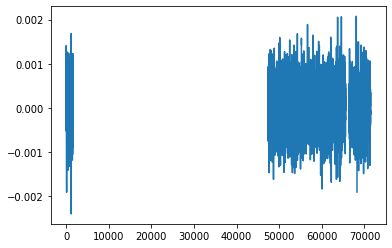

In [54]:
plt.plot(our_process[2341])
np.max(maximos)

In [85]:
np.log(np.max(maximos)+1)

6.841022036538049

In [86]:
np.log(4*365+1) #maximo posible..

7.2868764117507

In [79]:
det_state(7, 0, n_sta=10)

[(7.0, 6.3),
 (6.3, 5.6),
 (5.6, 4.8999999999999995),
 (4.8999999999999995, 4.199999999999999),
 (4.199999999999999, 3.4999999999999996),
 (3.4999999999999996, 2.8),
 (2.8, 2.0999999999999996),
 (2.0999999999999996, 1.3999999999999995),
 (1.3999999999999995, 0.6999999999999994),
 (0.6999999999999994, -6.661338147750939e-16)]

In [118]:
estados = det_state(0.15, 0, n_sta=5)
for l1, l2 in estados:
    print("Slice con deltas entre %f y %f dias"%(np.exp(l1)-1, np.exp(l2)-1), end='')
    print(" --- corresponde a %f y %f horas"%((np.exp(l1)-1)*24, (np.exp(l2)-1)*24))

Slice con deltas entre 0.161834 y 0.127497 dias --- corresponde a 3.884022 y 3.059924 horas
Slice con deltas entre 0.127497 y 0.094174 dias --- corresponde a 3.059924 y 2.260183 horas
Slice con deltas entre 0.094174 y 0.061837 dias --- corresponde a 2.260183 y 1.484077 horas
Slice con deltas entre 0.061837 y 0.030455 dias --- corresponde a 1.484077 y 0.730909 horas
Slice con deltas entre 0.030455 y 0.000000 dias --- corresponde a 0.730909 y 0.000000 horas


In [98]:
df["Period"].min() #minimo peridoo es 0.26 

0.259819659

In [108]:
states_values = det_state_2ways(1,-1, n_sta_up=16, n_sta_low=16) 

#states_t = det_state(0.15, 0, n_sta=5) # kepler time en ultimo slice
#states_t = det_state(0.25, 0, n_sta=5) #kepler time + un salto en ultimo slice
#states_t = det_state(0.5, 0, n_sta=5)
states_t = det_state(1, 0, n_sta=5)

In [109]:
fluxs = prepare_lc(coupled_LC[0]) #divide by min

transition_m = manual_HMM(coupled_deltaT_log[0], fluxs, states_values, states_t)
transition_m

array([[[0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        ...,
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ]],

       [[0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        ...,
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ]],

       [[0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.0

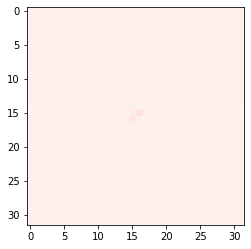

In [112]:
plt.imshow(transition_m[:,:,-2], cmap="RdPu", vmin=0, vmax=1) 

In [51]:
fluxs = prepare_lc(coupled_LC[5796]) #divide by min

transition_m = manual_HMM(coupled_deltaT_log[5796], fluxs, states_values, states_t)
transition_m

NameError: name 'coupled_LC' is not defined

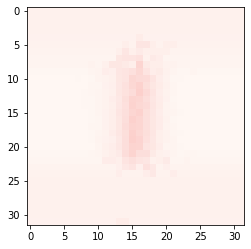

In [117]:
plt.imshow(transition_m[:,:,-1], cmap="RdPu", vmin=0, vmax=1)

In [132]:
fluxs = prepare_lc(our_process[1]) #divide by min
fluxs

array([       nan,        nan,        nan, ..., 0.11356014, 0.23694091,
       0.34023034])

In [134]:
%%time
transition_m = create_MTF_gN(fluxs,states_values,N=5)
transition_m

CPU times: user 53.7 ms, sys: 2.79 ms, total: 56.5 ms
Wall time: 53.1 ms


array([[[0.01123596, 0.01111111, 0.01149425, 0.01123596, 0.01123596],
        [0.01123596, 0.01111111, 0.01149425, 0.01123596, 0.01123596],
        [0.01123596, 0.01111111, 0.02298851, 0.01123596, 0.01123596],
        ...,
        [0.01123596, 0.01111111, 0.01149425, 0.01123596, 0.01123596],
        [0.01123596, 0.01111111, 0.01149425, 0.01123596, 0.01123596],
        [0.01123596, 0.01111111, 0.01149425, 0.01123596, 0.01123596]],

       [[0.01428571, 0.01388889, 0.01408451, 0.02777778, 0.01388889],
        [0.01428571, 0.01388889, 0.01408451, 0.01388889, 0.01388889],
        [0.01428571, 0.01388889, 0.01408451, 0.01388889, 0.01388889],
        ...,
        [0.01428571, 0.01388889, 0.01408451, 0.01388889, 0.01388889],
        [0.01428571, 0.01388889, 0.01408451, 0.02777778, 0.01388889],
        [0.01428571, 0.01388889, 0.01408451, 0.01388889, 0.01388889]],

       [[0.01123596, 0.01123596, 0.01123596, 0.01136364, 0.01123596],
        [0.01123596, 0.01123596, 0.01123596, 0.01136364, 0.0

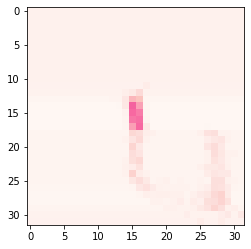

IndexError: index 1 is out of bounds for axis 2 with size 1

In [131]:
for i in range(5):
    plt.imshow(transition_m[:,:,i], cmap="RdPu", vmin=0, vmax=1)
    plt.show()

In [149]:
states_values = det_state_2ways(1,-1, n_sta_up=16, n_sta_low=16) 

### Comportamiento Falsos postiviso

In [136]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

(3976, 71427)

recuperando curva 1


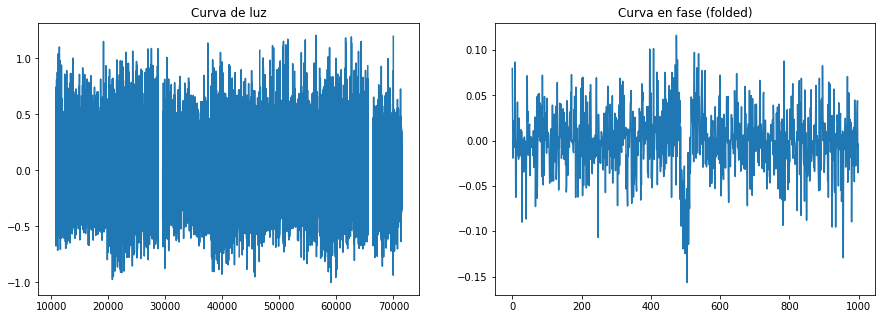

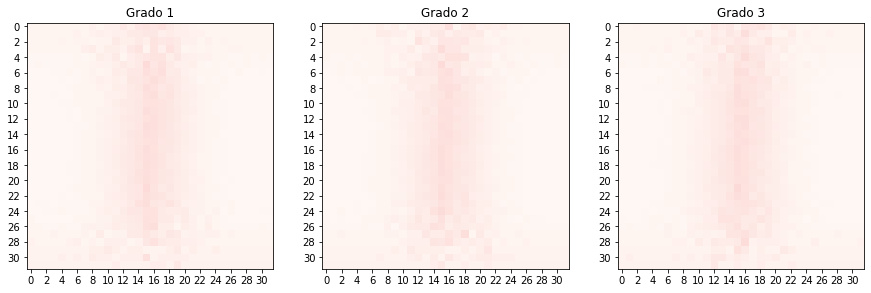

recuperando curva 2


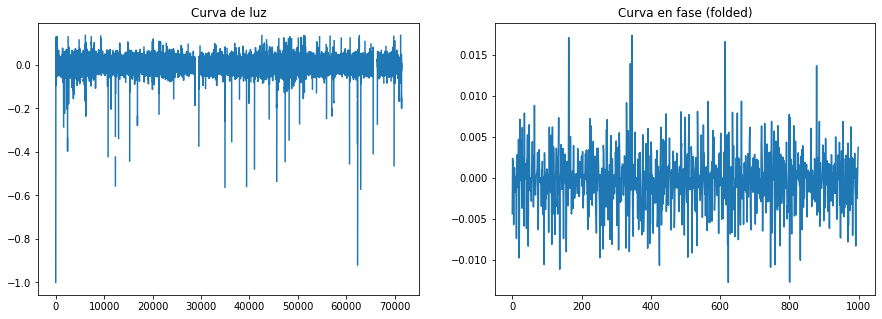

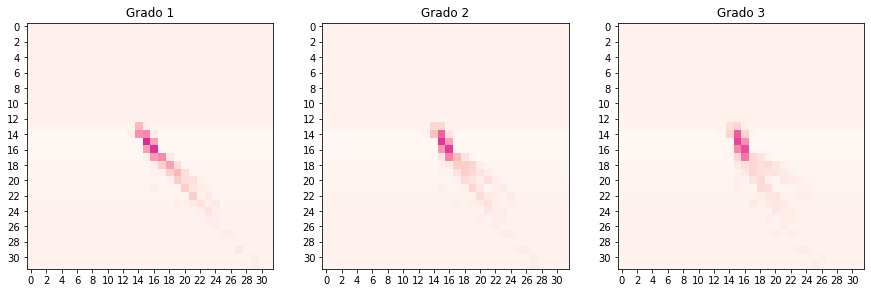

recuperando curva 3


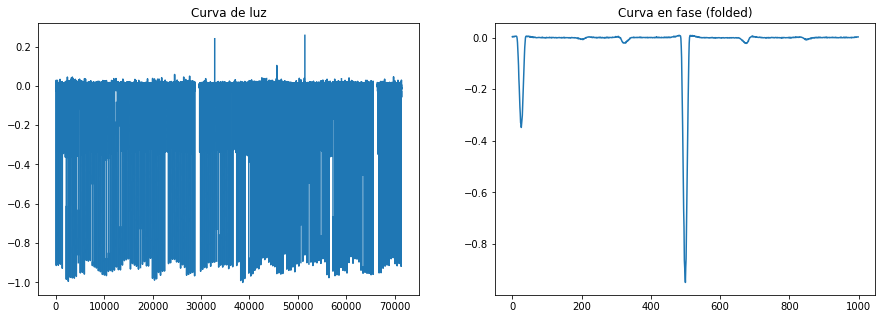

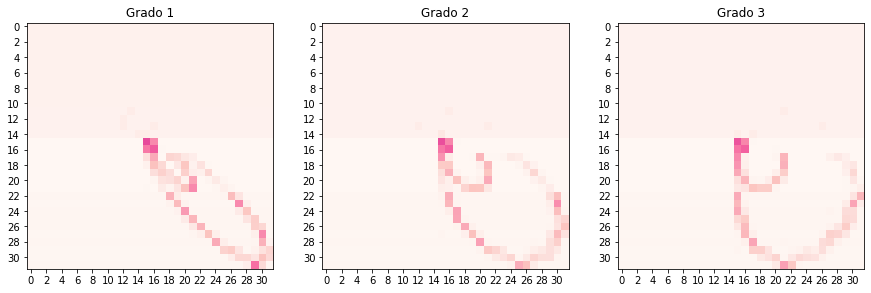

recuperando curva 4


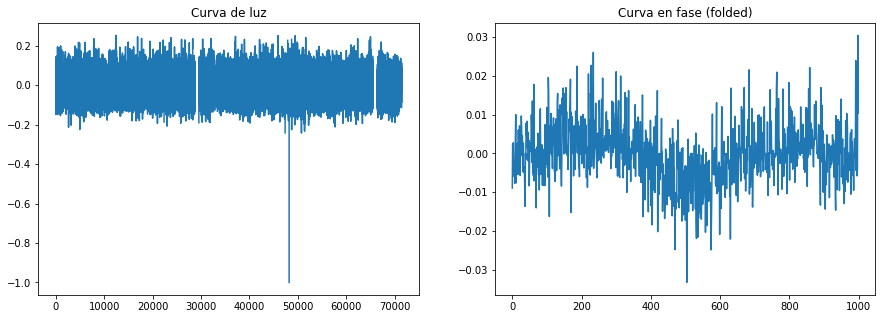

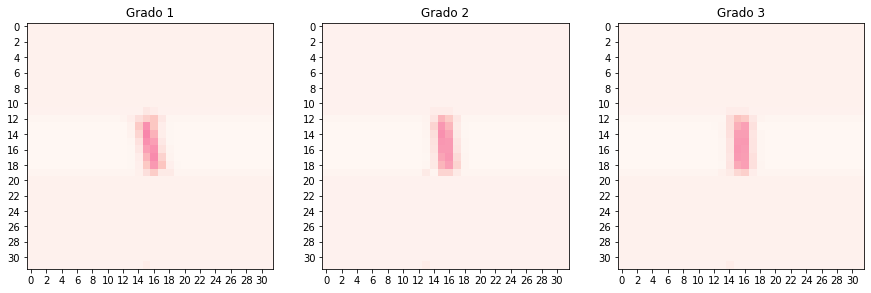

recuperando curva 5


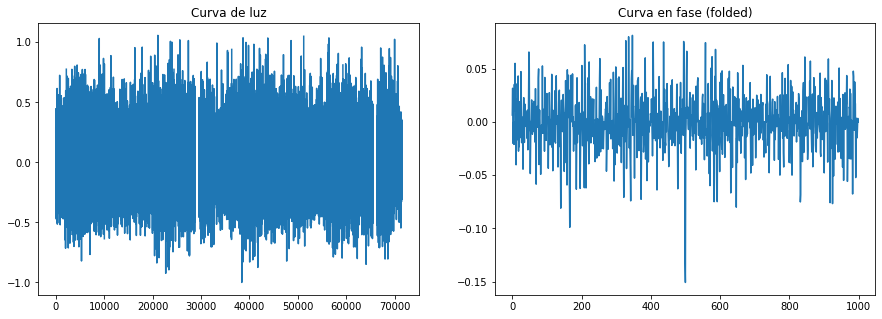

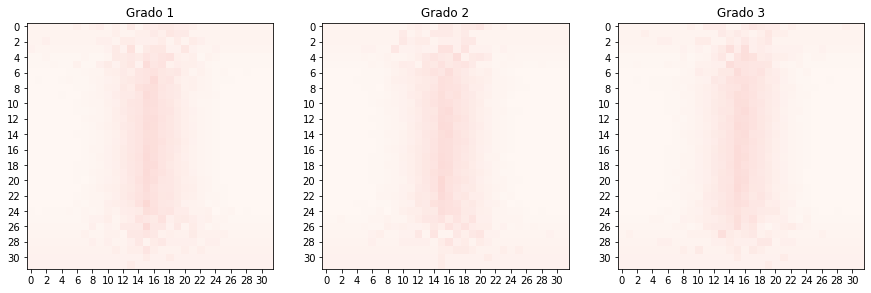

recuperando curva 6


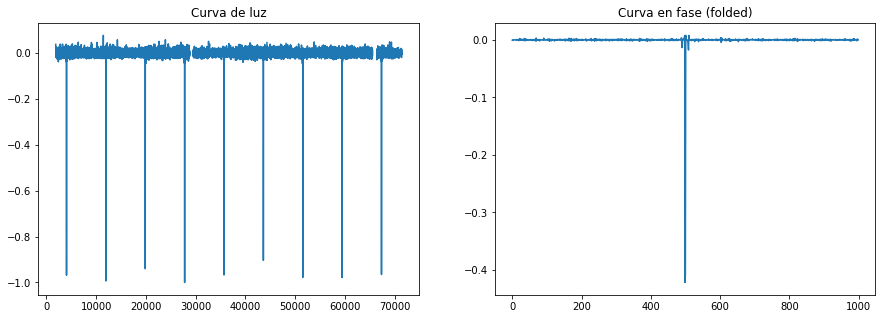

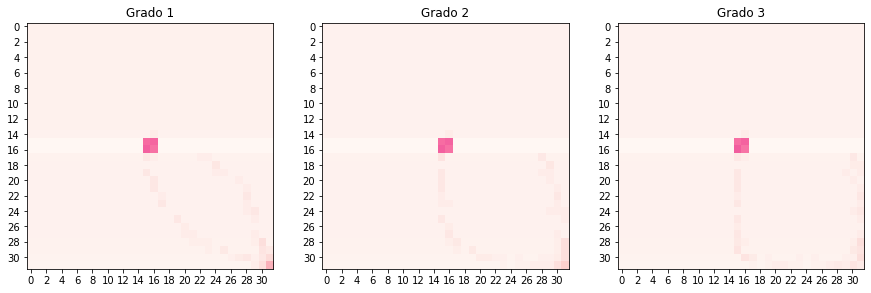

recuperando curva 7


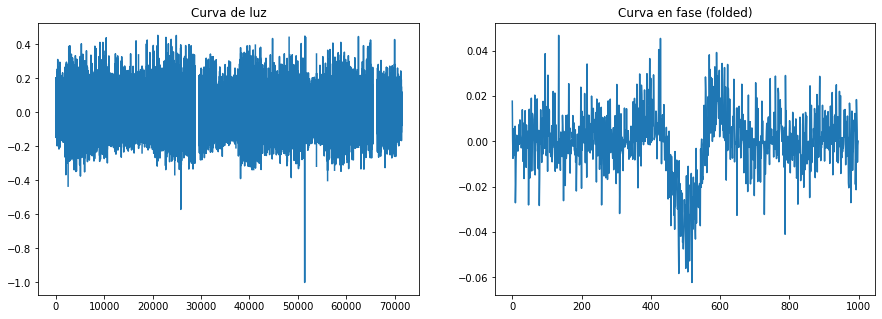

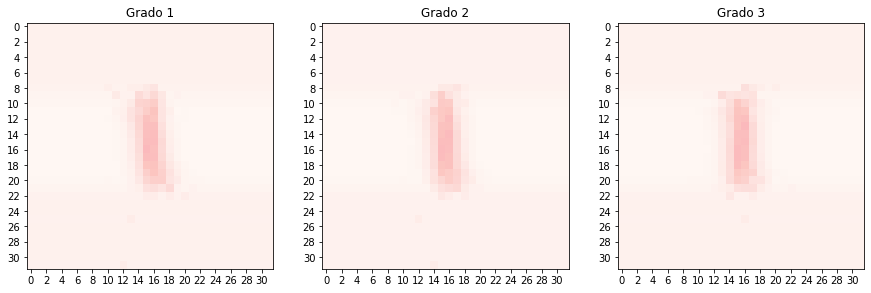

recuperando curva 8


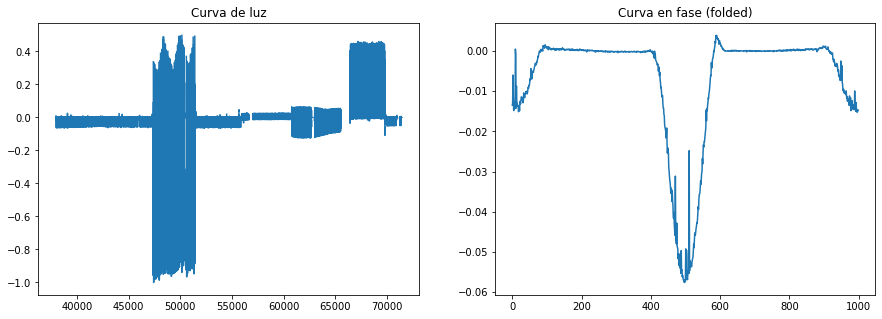

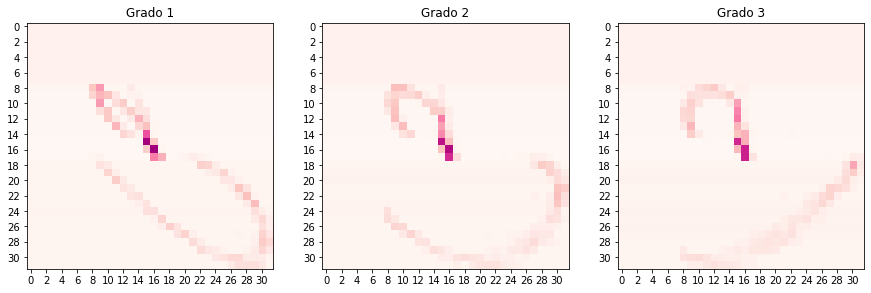

recuperando curva 9


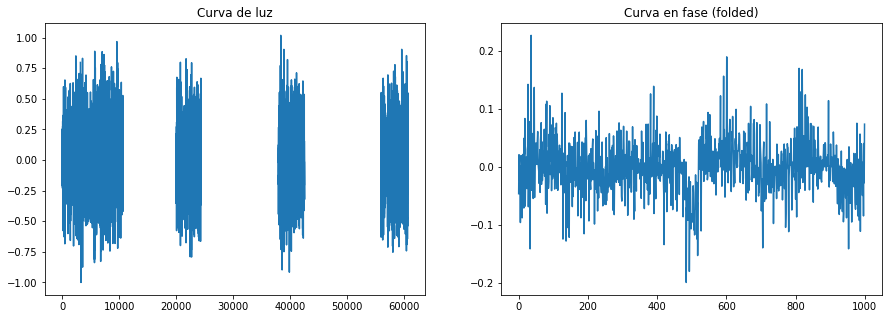

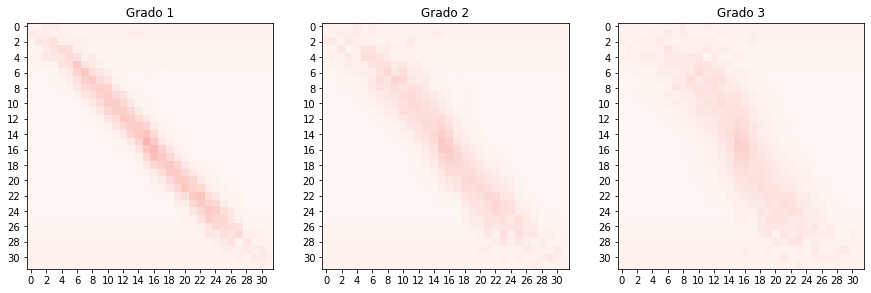

recuperando curva 10


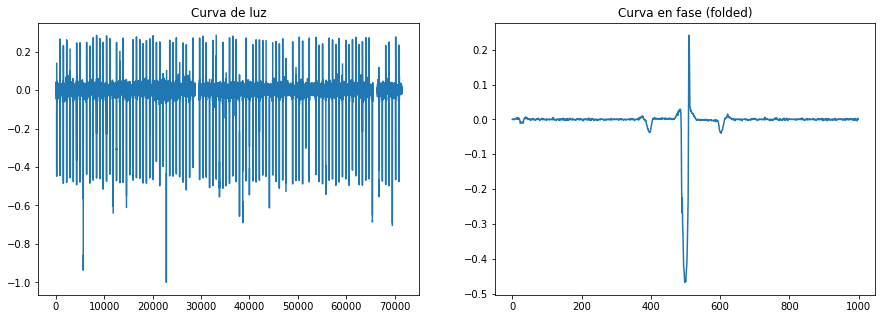

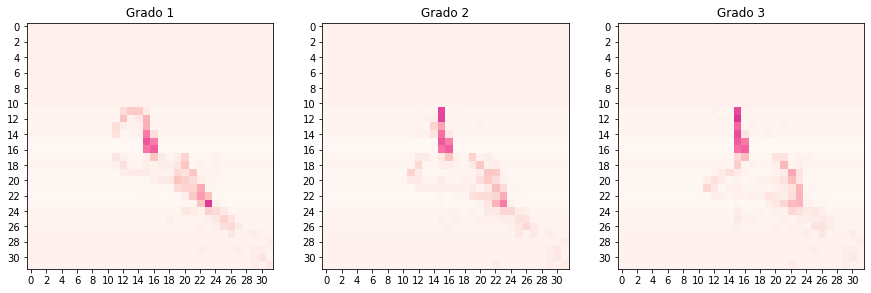

recuperando curva 11


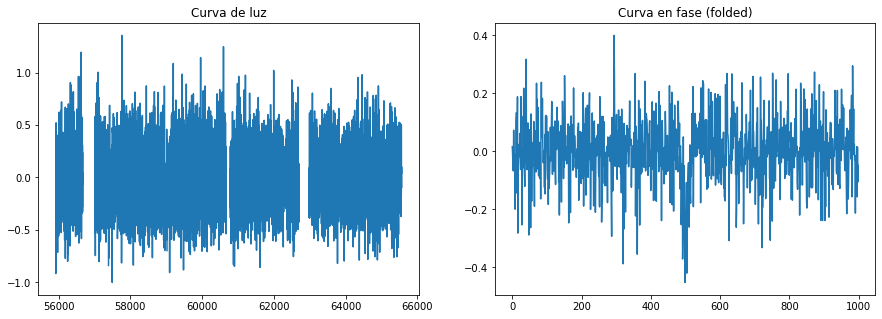

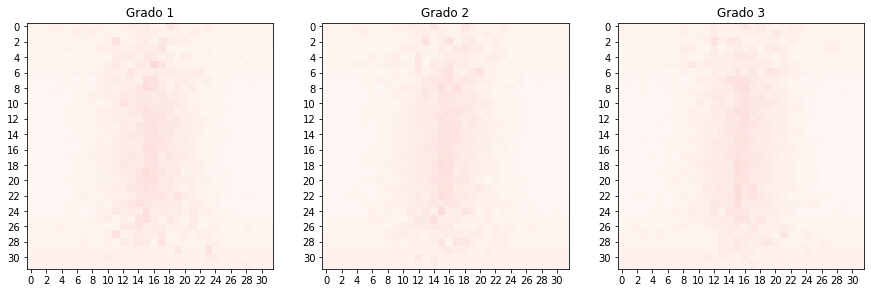

recuperando curva 12


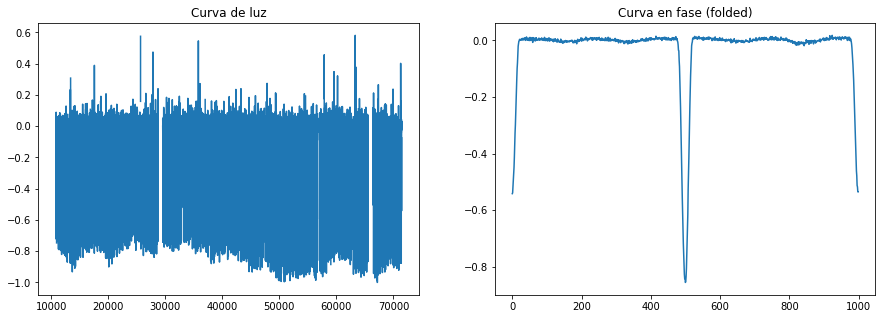

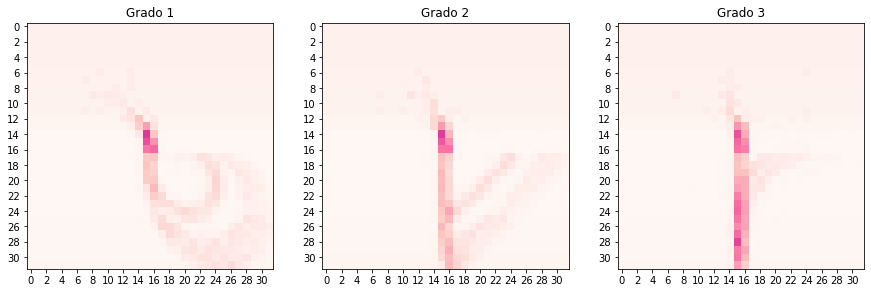

recuperando curva 13


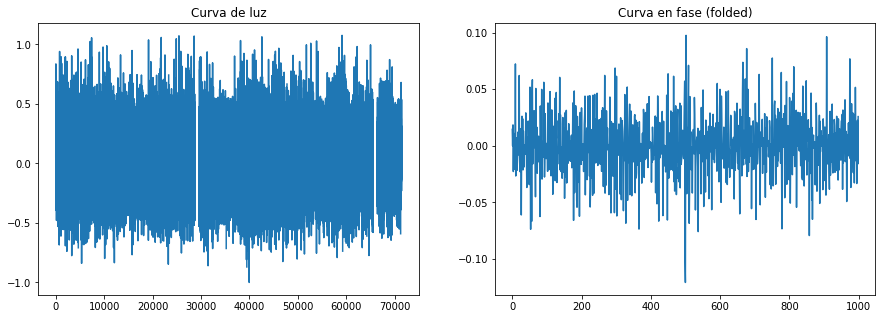

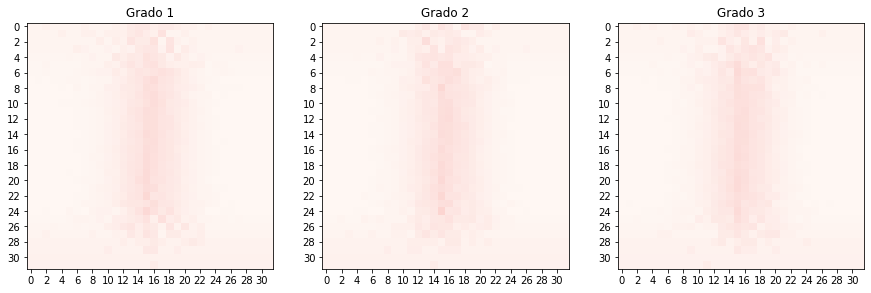

recuperando curva 14


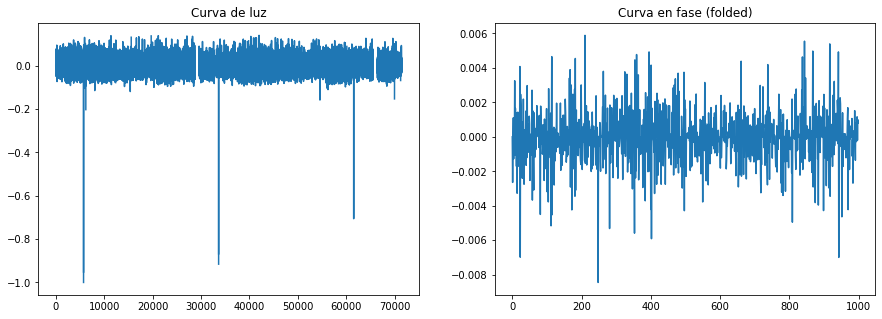

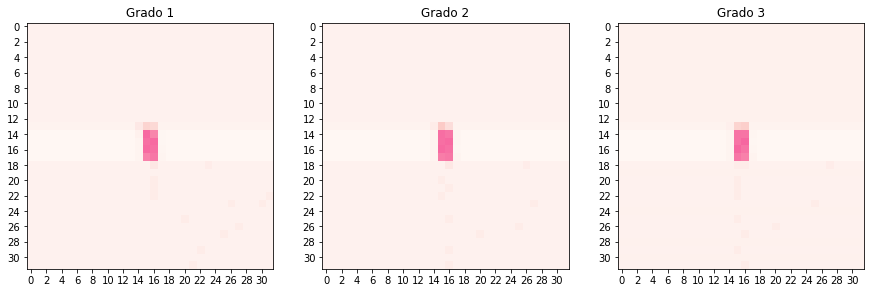

recuperando curva 15


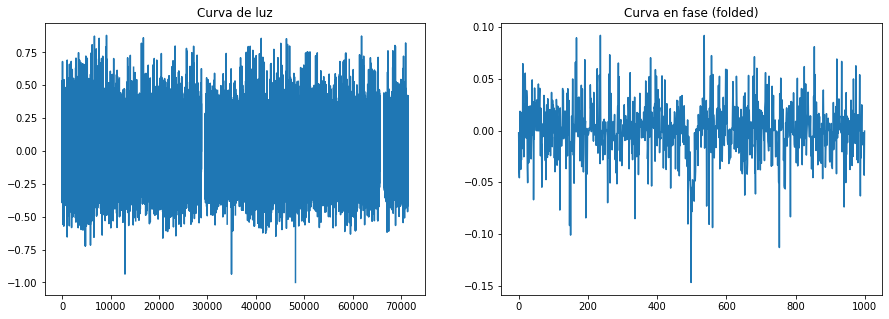

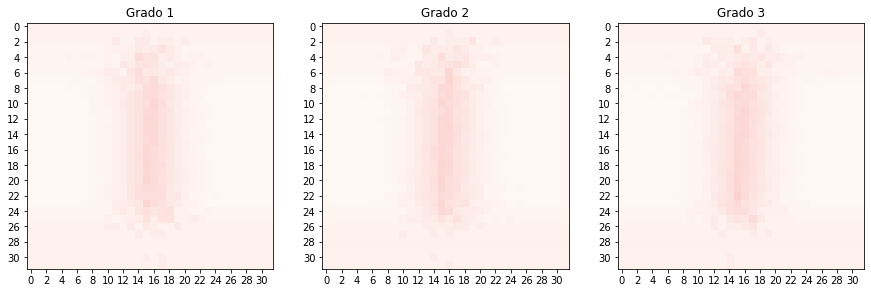

recuperando curva 16


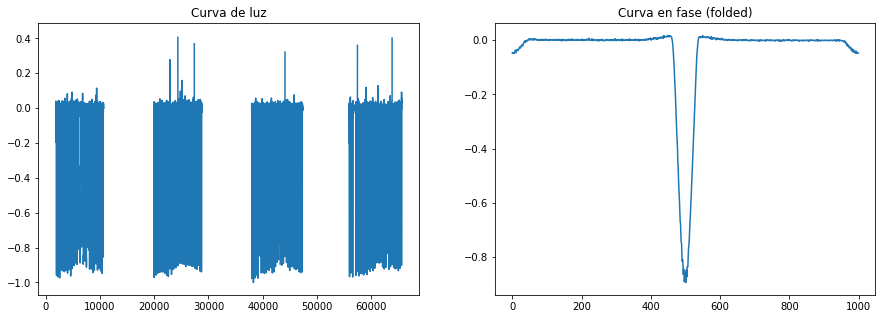

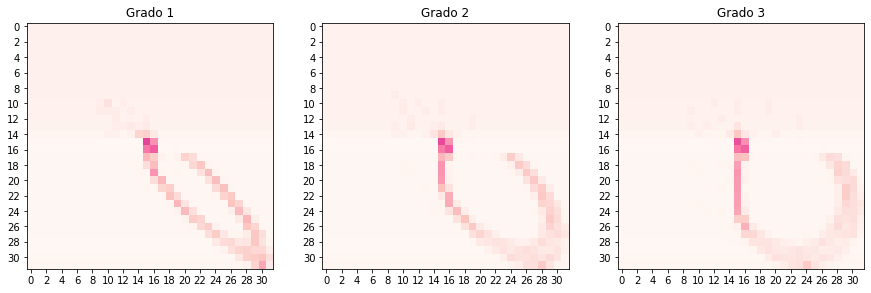

recuperando curva 17


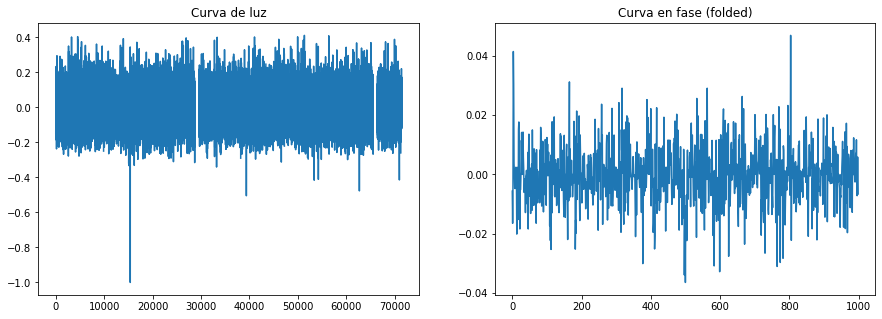

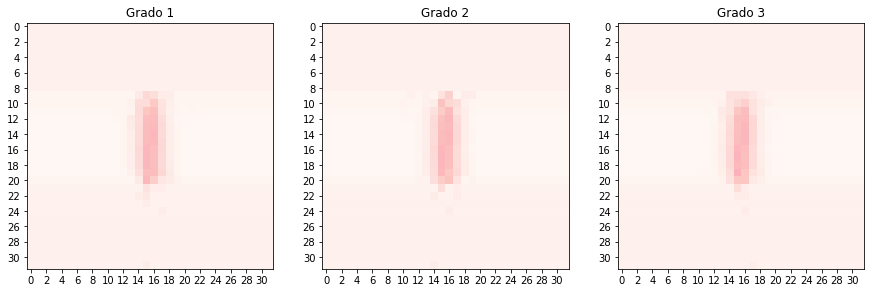

recuperando curva 18


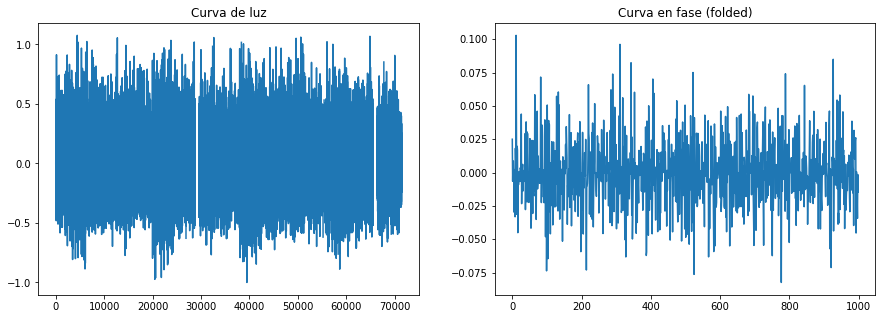

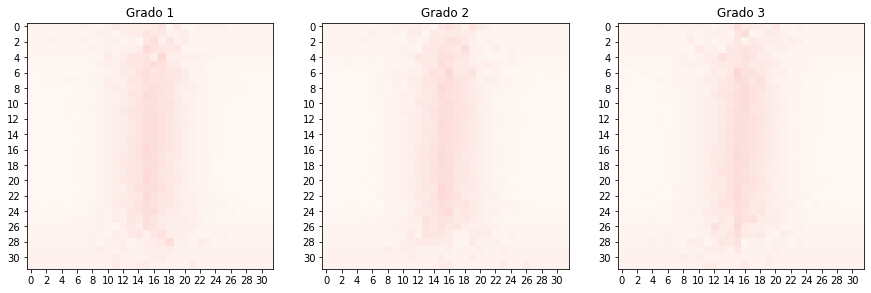

recuperando curva 19


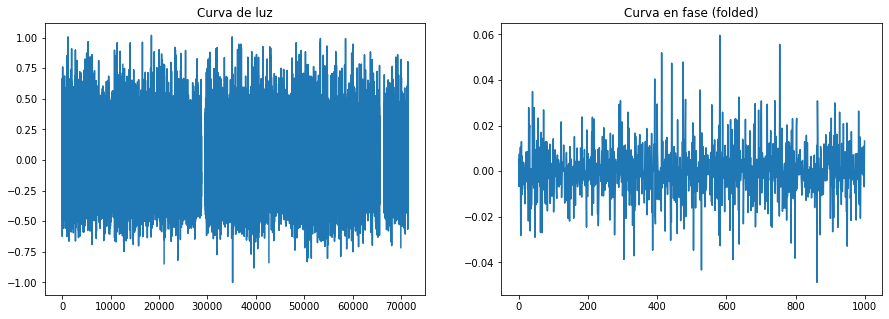

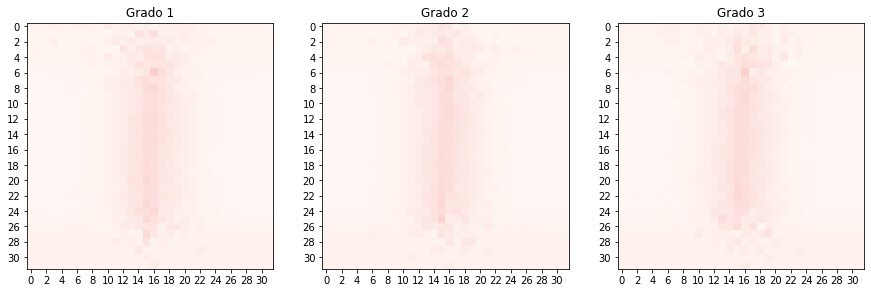

recuperando curva 20


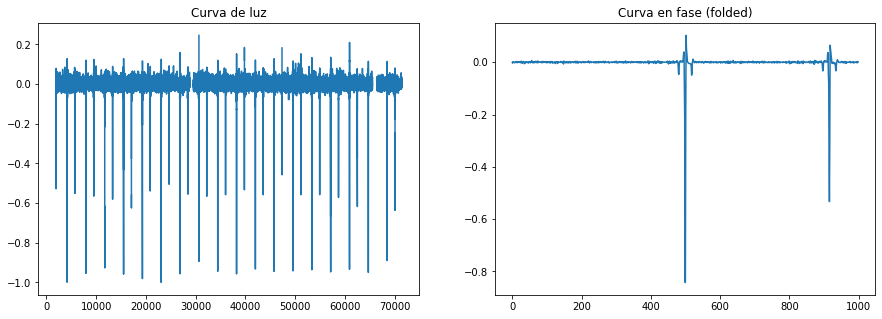

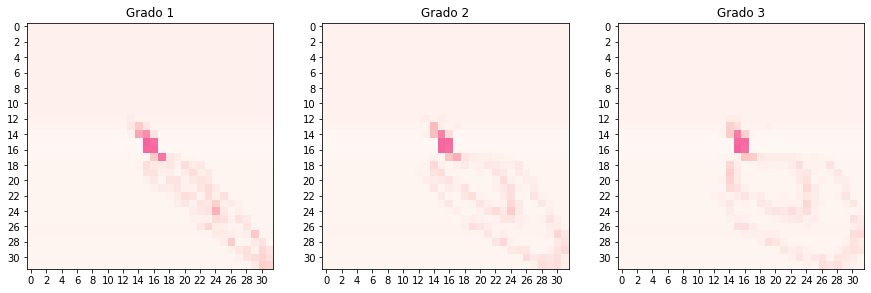

CPU times: user 45.3 s, sys: 9.22 s, total: 54.5 s
Wall time: 54.5 s


In [139]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    transition_m = create_MTF_gN(fluxs,states_values,N=5)

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 3,figsize= (15,5))
    for k in range(3):
        axx[k].imshow(transition_m[:,:,k], cmap='RdPu', vmin=0, vmax=1)
        axx[k].set_xticks(np.arange(0,transition_m.shape[0],2))
        axx[k].set_yticks(np.arange(0,transition_m.shape[0],2))
        axx[k].set_xticklabels(labels_x)
        axx[k].set_yticklabels(labels_x)
        axx[k].set_title("Grado "+str(k+1))
    plt.show()

### Comportamiento Confirmados

In [147]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1


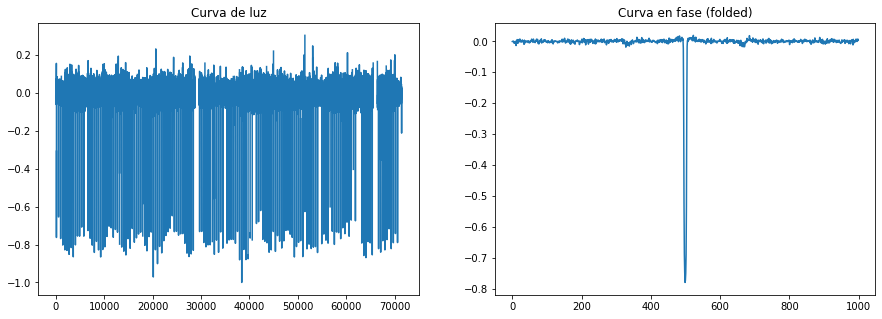

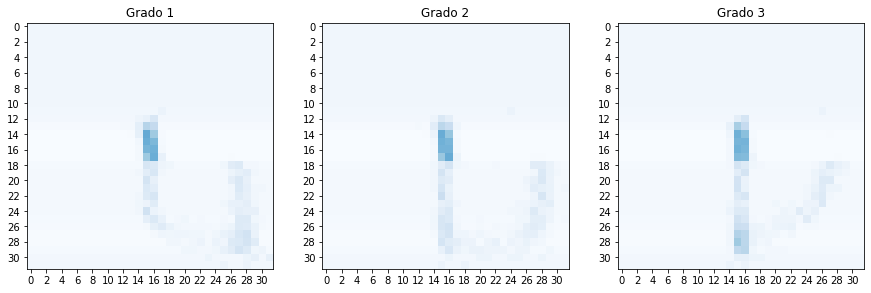

recuperando curva 2


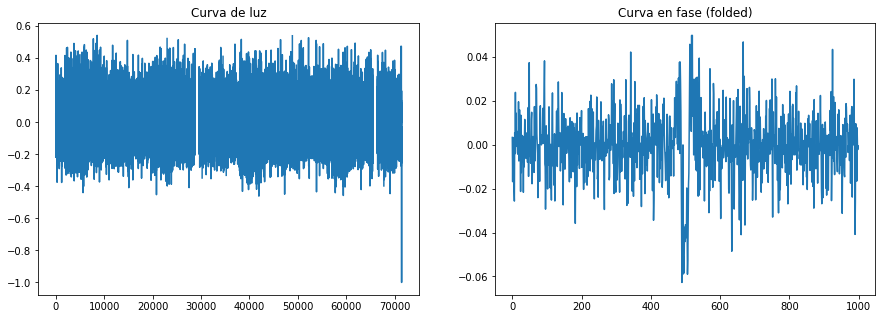

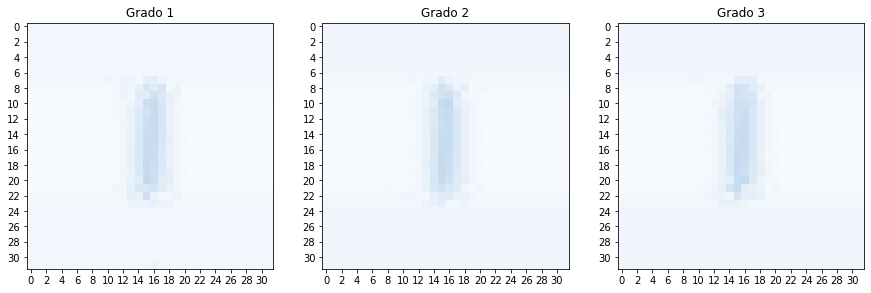

recuperando curva 3


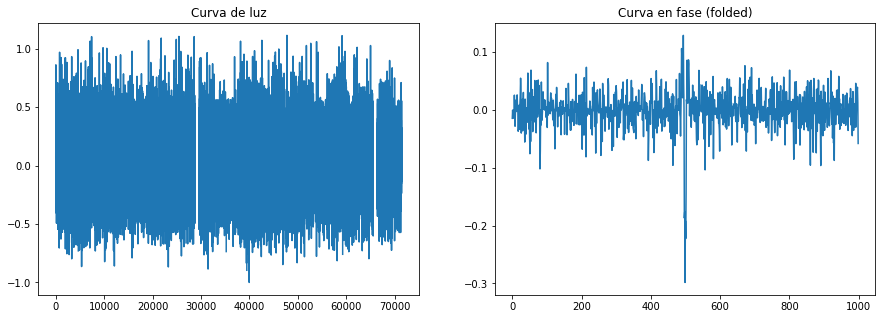

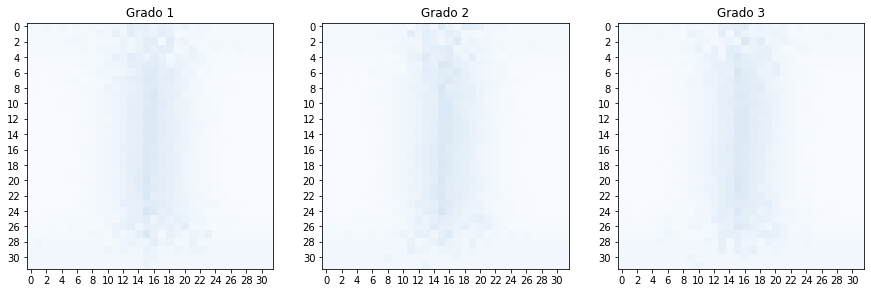

recuperando curva 4


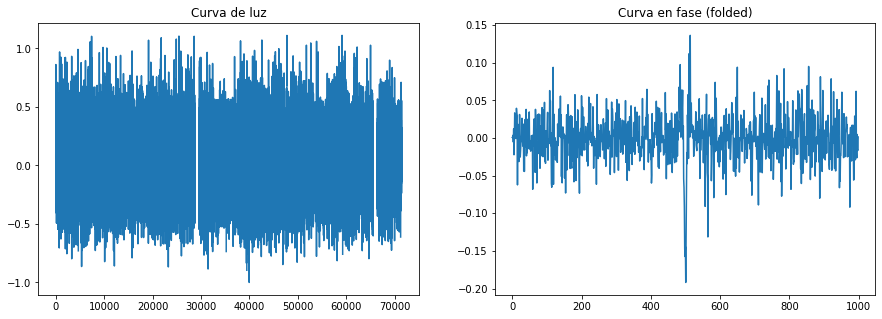

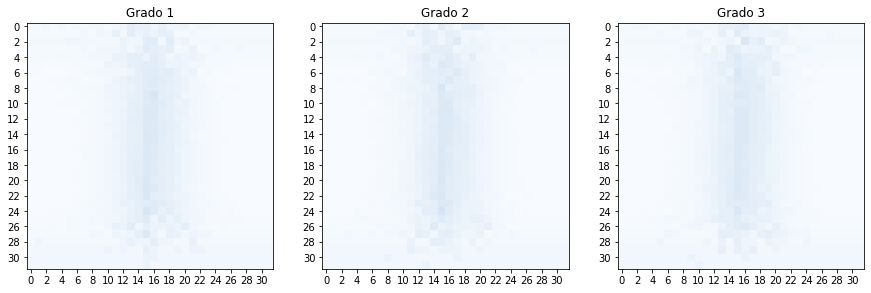

recuperando curva 5


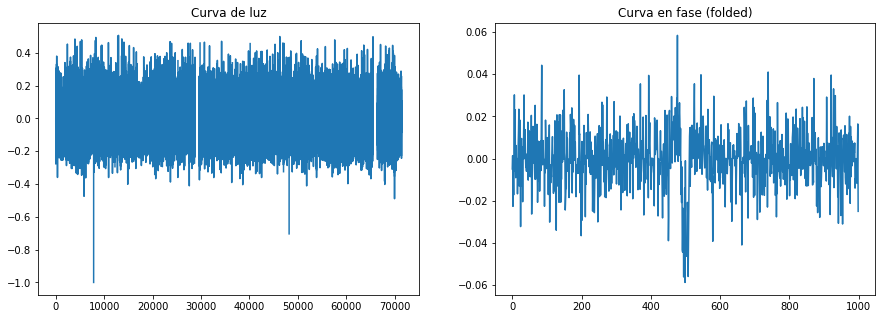

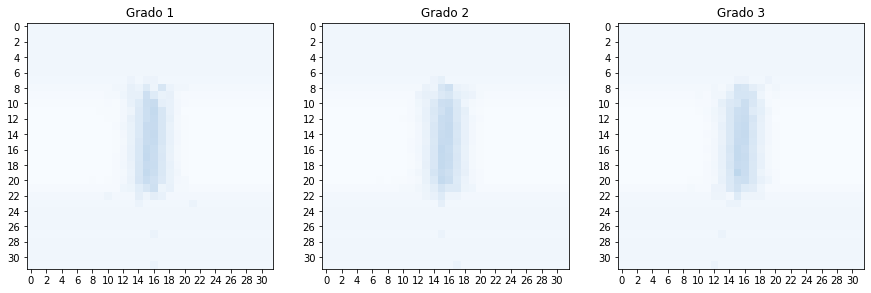

recuperando curva 6


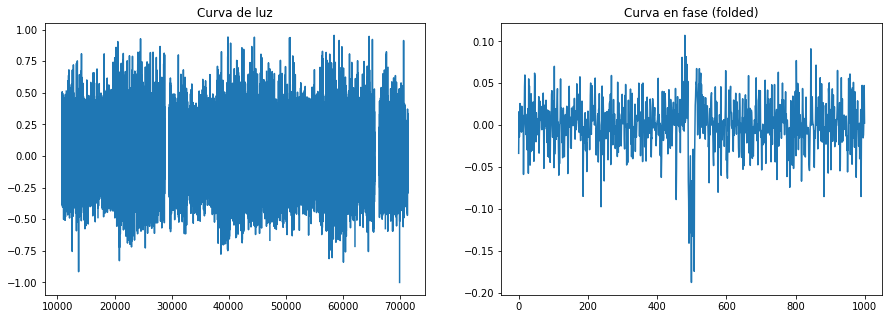

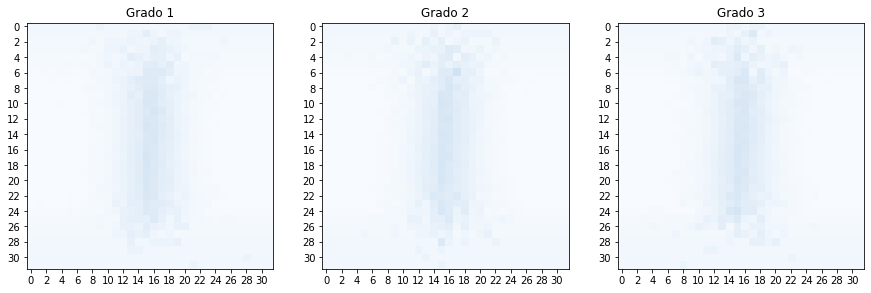

recuperando curva 7


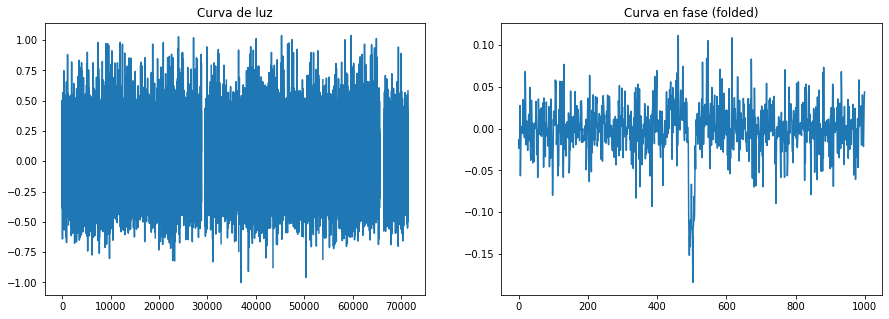

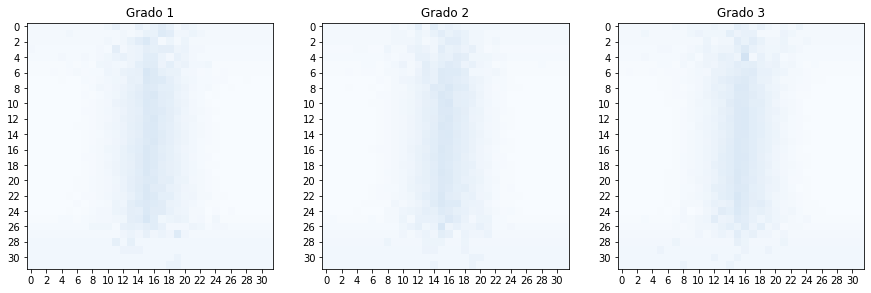

recuperando curva 8


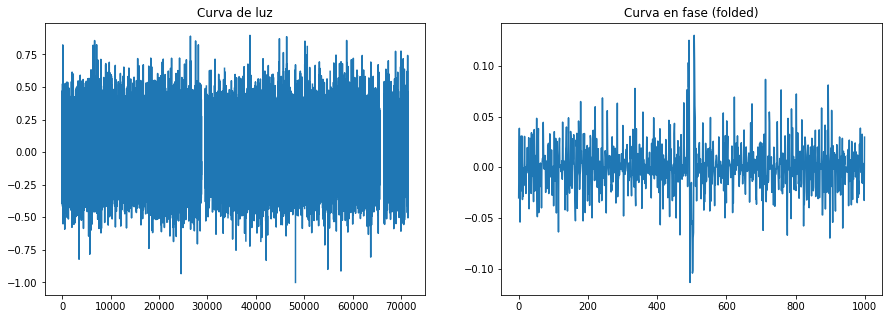

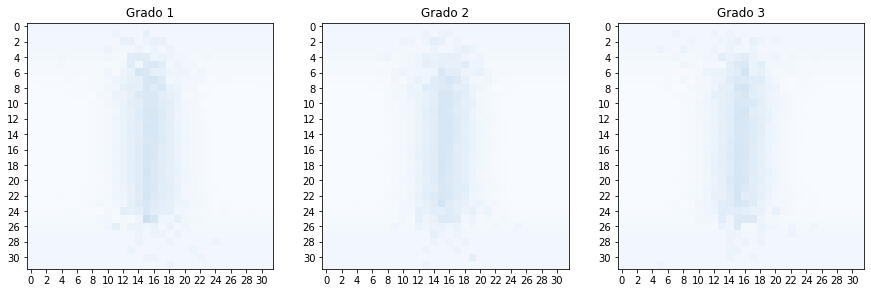

recuperando curva 9


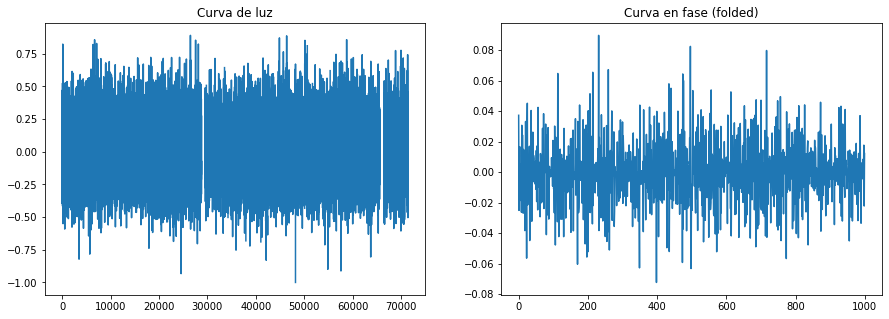

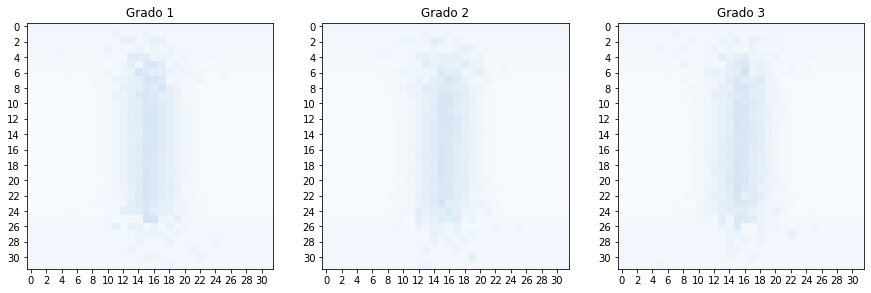

recuperando curva 10


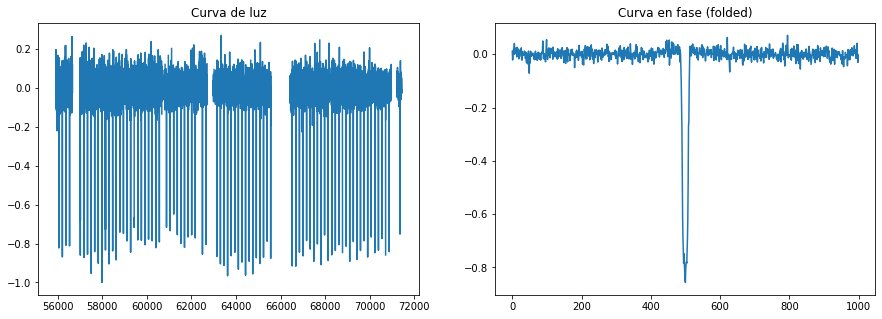

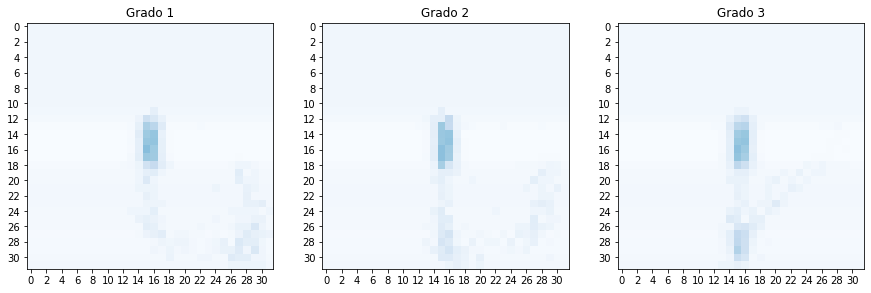

recuperando curva 11


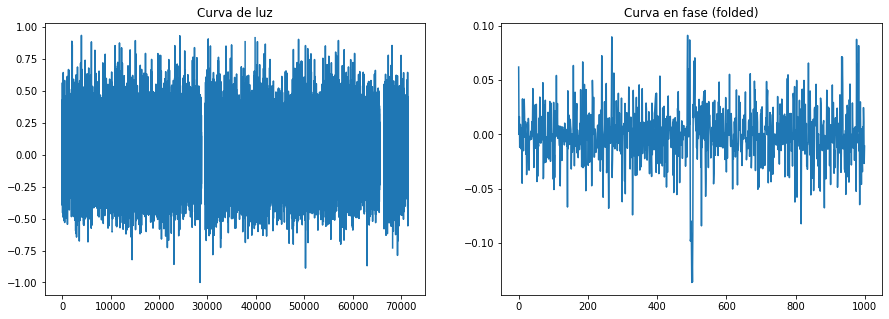

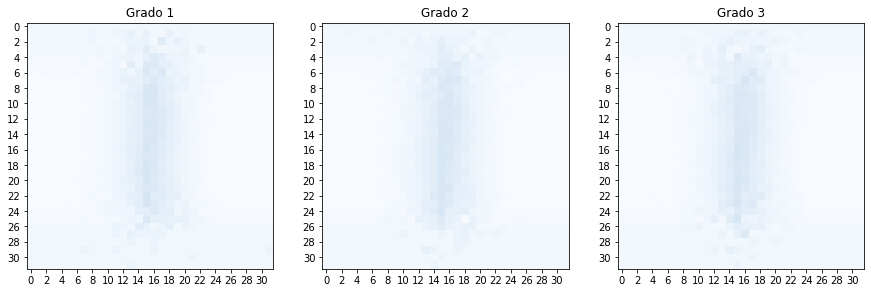

recuperando curva 12


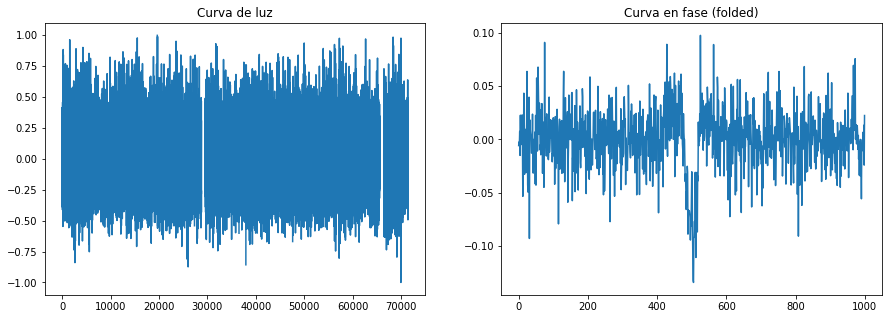

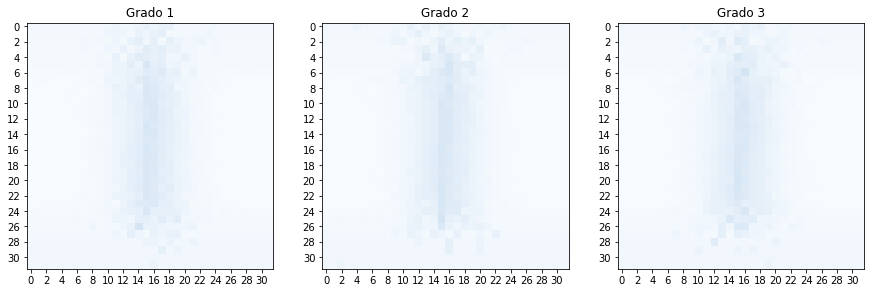

recuperando curva 13


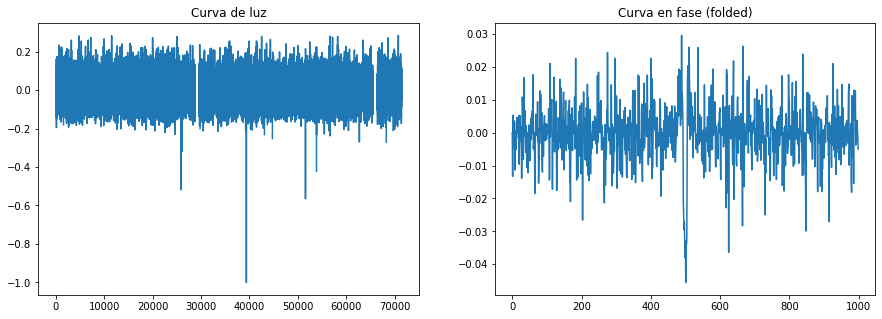

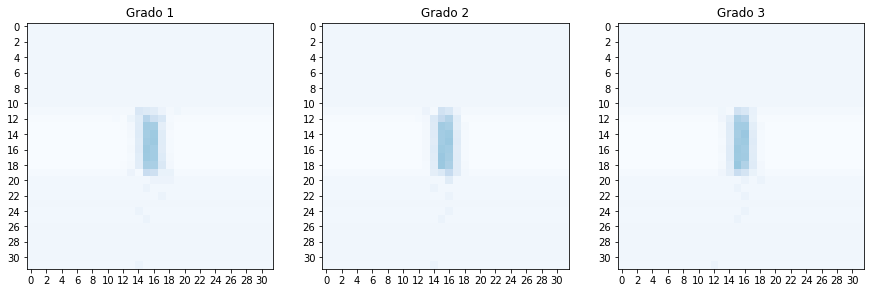

recuperando curva 14


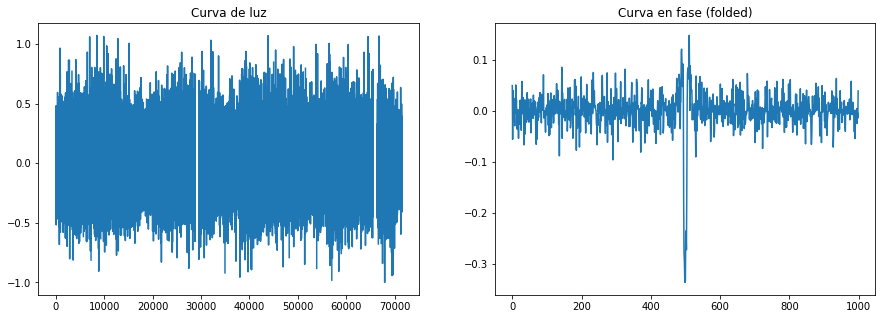

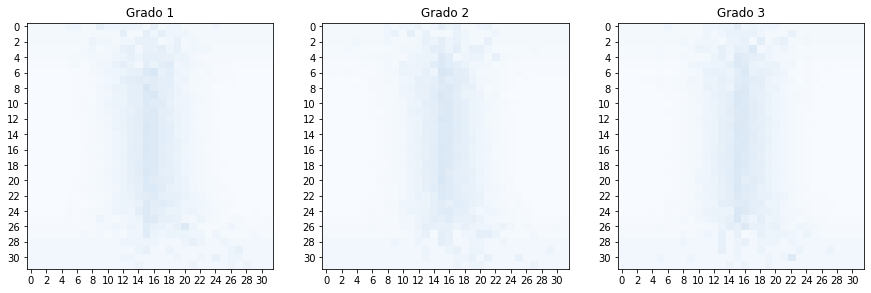

recuperando curva 15


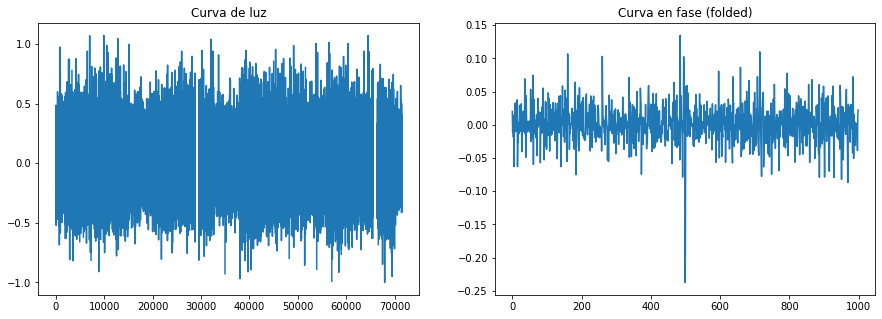

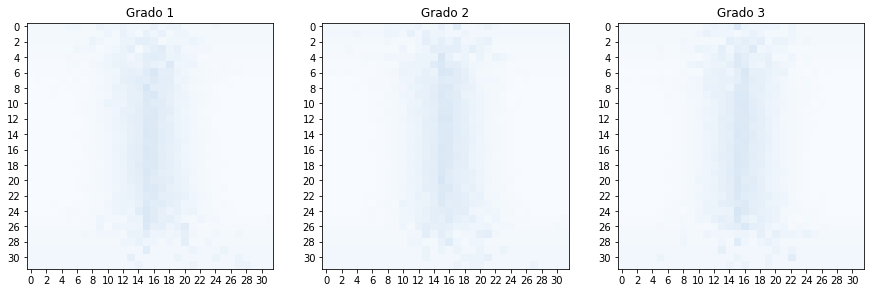

recuperando curva 16


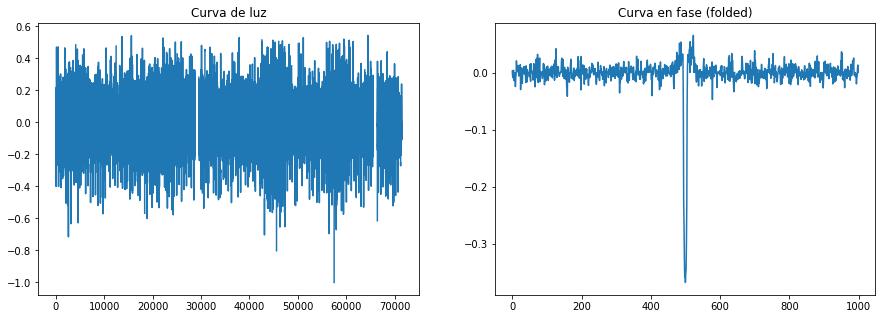

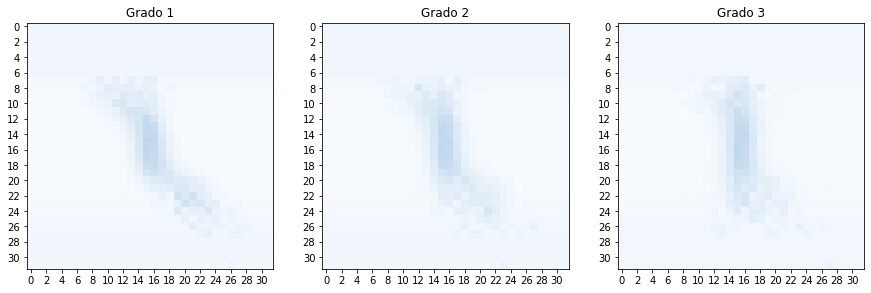

recuperando curva 17


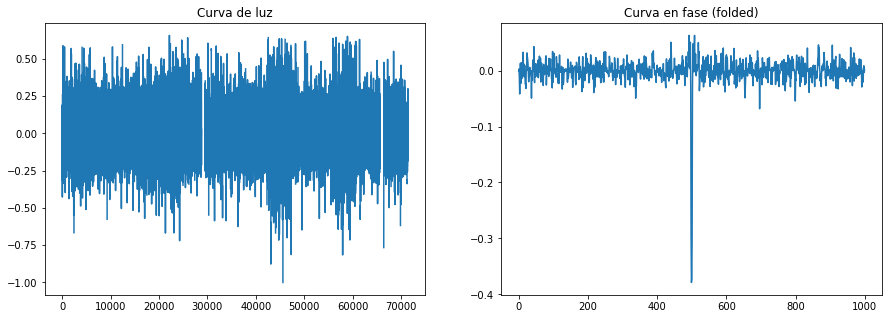

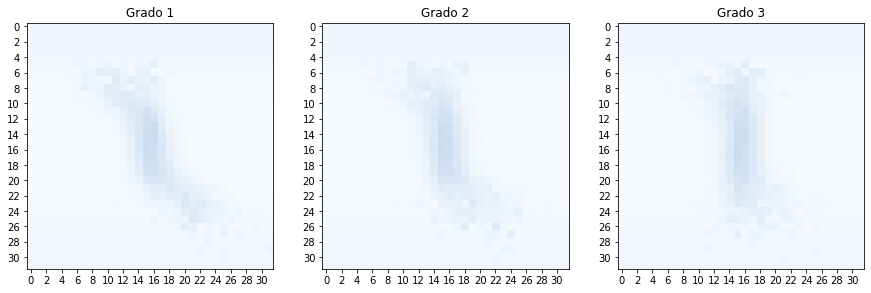

recuperando curva 18


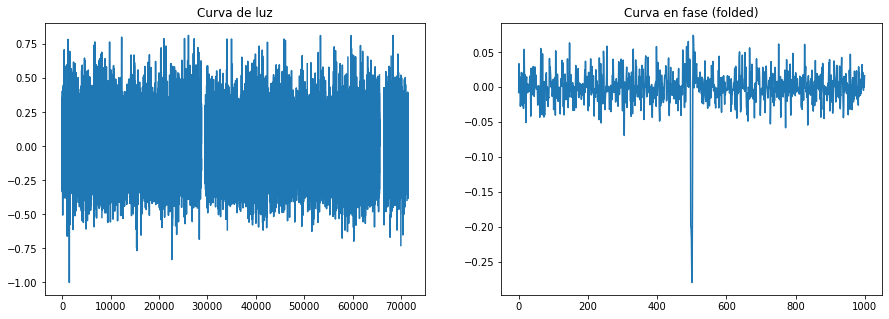

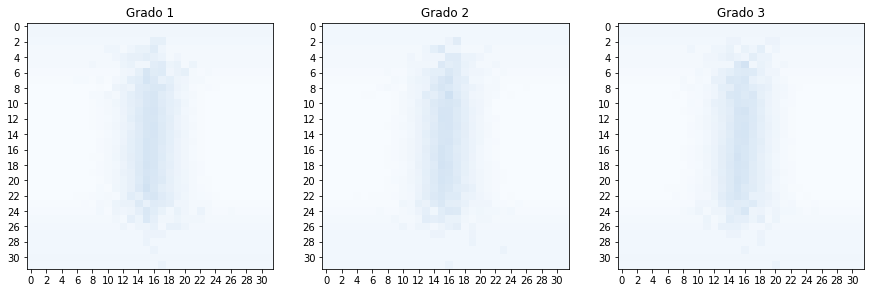

recuperando curva 19


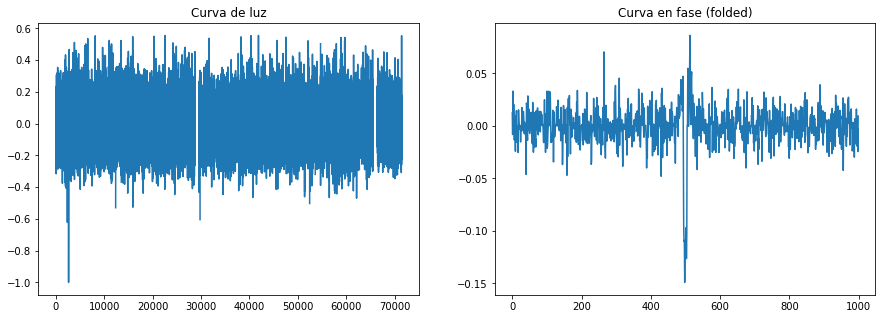

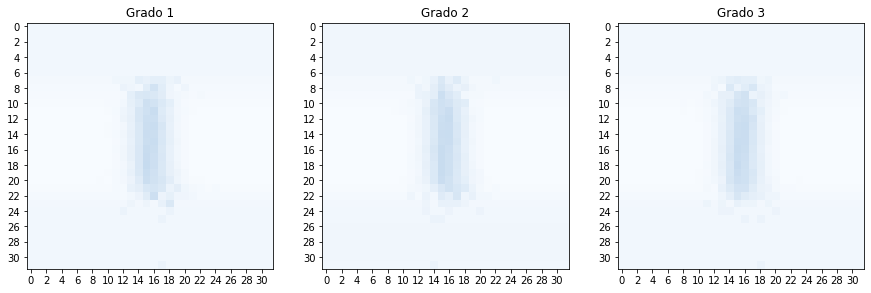

recuperando curva 20


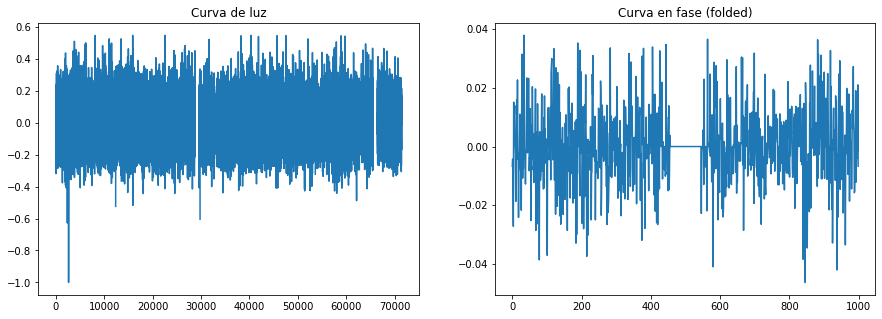

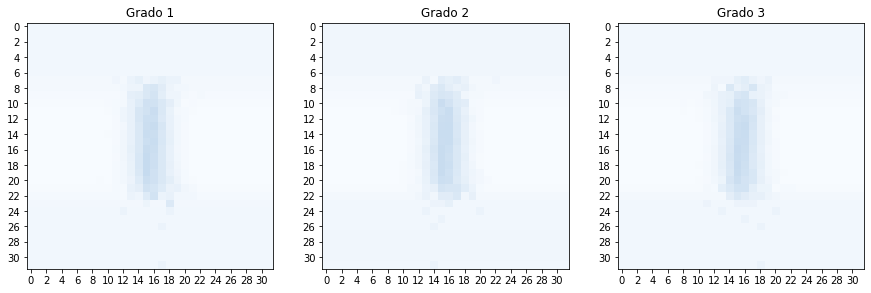

CPU times: user 39.1 s, sys: 5.47 s, total: 44.6 s
Wall time: 44.5 s


In [150]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_con][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_con][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    
    transition_m = create_MTF_gN(fluxs,states_values,N=5)

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 3,figsize= (15,5))
    for k in range(3):
        axx[k].imshow(transition_m[:,:,k], cmap='Blues', vmin=0, vmax=1)
        axx[k].set_xticks(np.arange(0,transition_m.shape[0],2))
        axx[k].set_yticks(np.arange(0,transition_m.shape[0],2))
        axx[k].set_xticklabels(labels_x)
        axx[k].set_yticklabels(labels_x)
        axx[k].set_title("Grado "+str(k+1))
    plt.show()

### Normal (izq - der) NO BORRAR

In [8]:
!ls /work/work_teamEXOPLANET/MTF_gN/no_invertidos/

MTF_u16_d16.npy  MTF_u32_d32.npy  MTF_u64_d16.npy  MTF_u8_d16.npy
MTF_u16_d32.npy  MTF_u32_d64.npy  MTF_u64_d32.npy  MTF_u8_d32.npy
MTF_u16_d64.npy  MTF_u32_d8.npy   MTF_u64_d4.npy   MTF_u8_d64.npy
MTF_u16_d8.npy	 MTF_u4_d4.npy	  MTF_u64_d64.npy  MTF_u8_d8.npy
MTF_u32_d16.npy  MTF_u4_d64.npy   MTF_u64_d8.npy


In [4]:
ups=[4,64]
downs=[4,64]

In [5]:
for arriba in ups:
    for abajo in downs:        
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend, tipo='min')
            
            transition_m = create_MTF_gN(fluxs,n_up=arriba,n_down=abajo,N=10)
            matrices.append(transition_m)
            i+=1

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_gN/no_invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 4 4


/users/fmena/PIIC19/code/obj1/code_MTF.py:50: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'states' of function 'add_transitions_gN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "code_MTF.py", line 34:
@njit(parallel=False, cache=True, fastmath=False)  #no se pudo paralelizar por el acceso a lista "ind -1" y el if
def add_transitions_gN(fluxs, transition_m, states, n):
^

  add_transitions_gN(fluxs, transition_m, states, n)
/users/fmena/PIIC19/code/obj1/code_MTF.py:50: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'estados' of function 'det_celda'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File 

Creada la configuracion
ARRIBA Y ABAJO 4 64
Creada la configuracion
ARRIBA Y ABAJO 64 4
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion


In [13]:
!ls /work/work_teamEXOPLANET/MTF_gN/invertidos

MTF_u16_d16.npy  MTF_u32_d32.npy  MTF_u64_d16.npy  MTF_u8_d16.npy
MTF_u16_d32.npy  MTF_u32_d64.npy  MTF_u64_d32.npy  MTF_u8_d32.npy
MTF_u16_d64.npy  MTF_u32_d8.npy   MTF_u64_d4.npy   MTF_u8_d64.npy
MTF_u16_d8.npy	 MTF_u4_d4.npy	  MTF_u64_d64.npy  MTF_u8_d8.npy
MTF_u32_d16.npy  MTF_u4_d64.npy   MTF_u64_d8.npy


In [12]:
for arriba in ups:
    for abajo in downs:        
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend[::-1], tipo='min')
            
            transition_m = create_MTF_gN(fluxs,n_up=arriba,n_down=abajo,N=10)
            matrices.append(transition_m)
            i+=1

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_gN/invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 4 4
Creada la configuracion
ARRIBA Y ABAJO 4 64
Creada la configuracion
ARRIBA Y ABAJO 64 4
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion


In [ ]:
## revisar lo de arriba y el std noise en mi pc... luego pushear y  ver cluster en datacent

In [ ]:
## std
norm_stand = stats.norm(loc=0, scale=1)
states_prob, states_values = det_state_norm(s, dis=norm_stand)

fluxs = prepare_lc(lc_our_detrend, tipo='std')

#guardarc con onombre ruido
np.save(folder2+'MTF_noise_s'+str(s)+".npy", matrices)
